In [1]:
from sigvisa.experiments.aftershock_region import load_waves, load_evs, evids, stas

In [10]:
def xcorr_valid(a,b):
    a = (a - np.mean(a)) / (np.std(a) * np.sqrt(len(a)))
    b = (b - np.mean(b)) / (np.std(b) * np.sqrt(len(a)))

    xc = my_xc(a, b)
    xcmax = np.max(xc)
    offset = np.argmax(xc)
    return xcmax, offset, xc


import scipy.weave as weave
from scipy.weave import converters
def my_xc(a, b):
    # assume len(a) < len(b)
    n = len(b) - len(a)+1
    m = len(a)
    r = np.zeros((n,))
    a_normed = a / np.linalg.norm(a)
    code="""
for(int i=0; i < n; ++i) {
    double b_norm = 0;
    double cc = 0;
    for (int j=0; j < m; ++j) {
        cc += a_normed(j)*b(i+j);
        b_norm += b(i+j)*b(i+j);
    }
    cc /= sqrt(b_norm);
    r(i) = cc;
}
"""
    weave.inline(code,['n', 'm', 'a_normed', 'b', 'r',],type_converters = converters.blitz,verbose=2,compiler='gcc')
    """
    for i in range(n):
        window = b[i:i+len(a)]
        w_normed = window / np.linalg.norm(window)
        r[i] = np.dot(a_normed, w_normed)
    """
    return r

In [11]:
waves = load_waves(filter_str="freq_0.8_4.5;forcehz_20")

In [12]:
rel_atimes = dict()
srate = 20
n = len(evids)
xcmax1, xcmax2, offset1, offset2 = {}, {}, {}, {}

patches={}

for sta in stas:
    xcmax1[sta] = np.zeros((n, n))
    xcmax2[sta] = np.zeros((n, n))
    offset1[sta] = np.zeros((n, n))
    offset2[sta] = np.zeros((n, n))
    for i, evid1 in enumerate(evids):
        try:
            w1 = waves[evid1][sta]
        except KeyError:
            continue
        
        
        assert(w1['srate']==srate)
        
        try:
            atime_s = w1['event_arrivals'][0,2]-w1['stime']
        except IndexError:
            atime_s = 30.0
        
        p_start_idx = int((atime_s-2)*srate)
        p1_end_idx = int((atime_s+4)*srate)
        p2_end_idx = int((atime_s+12)*srate)
        
        if w1['npts'] < p2_end_idx: continue
        
        patch1 = w1.data.data[p_start_idx:p1_end_idx]
        patch2 = w1.data.data[p_start_idx:p2_end_idx]        
        
        patches[(sta, evid1)] = (p_start_idx, p1_end_idx, p2_end_idx)
        
        for j, evid2 in enumerate(evids):
            if j <= i: continue

            try:
                w2 = waves[evid2][sta]
            except KeyError:
                continue
            assert(w2['srate']==srate)                
                
            try:
                atime_s = w2['event_arrivals'][0,2]-w2['stime']
            except IndexError:
                atime_s = 30.0
                
            sidx = int((atime_s-8.0)*srate)
            eidx = int((atime_s+25.0)*srate)
            
            if w2['npts'] < eidx:
                continue
            
            w2_valid = w2.data.data[sidx:eidx]

            xcmax1[sta][i,j], offset1[sta][i,j], _ = xcorr_valid(patch1, w2_valid)
            xcmax2[sta][i,j], offset2[sta][i,j], _ = xcorr_valid(patch2, w2_valid)
            offset1[sta][i,j] += sidx
            offset2[sta][i,j] += sidx
            
    print sta

ASAR
KURK
MKAR
SONM
BVAR
FITZ
CTA
CMAR
WRA
ZALV
MJAR
AKTO
INK


In [13]:
def get_correlated_waves(sta, i,j):
    evid1 = evids[i]
    evid2 = evids[j]
    w1 = waves[evid1][sta]
    w2 = waves[evid2][sta]
    
    srate = 20.0
    p_start_idx, p1_end_idx, p2_end_idx = patches[(sta, evid1)]
    patch1 = w1.data[p_start_idx:p1_end_idx]
    patch2 = w1.data[p_start_idx:p2_end_idx]
    return w1, w2, patch1, patch2



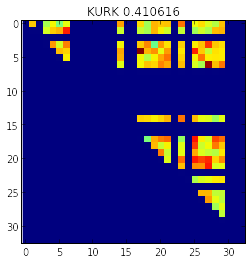

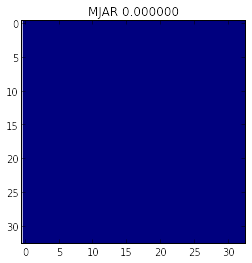

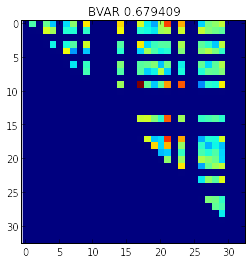

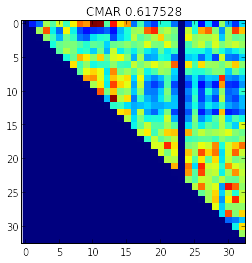

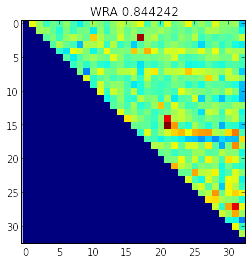

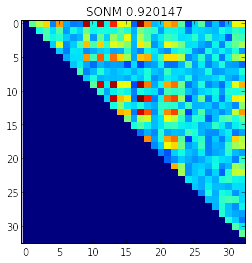

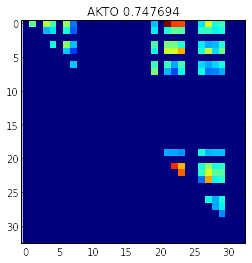

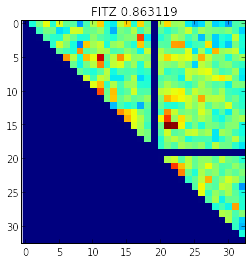

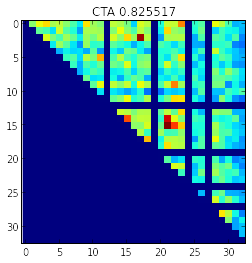

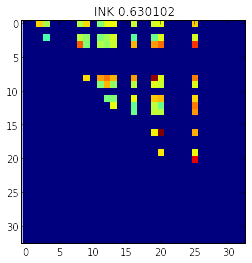

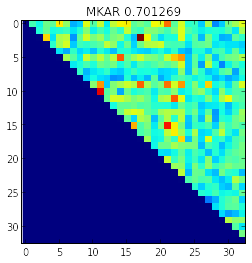

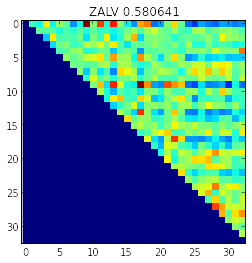

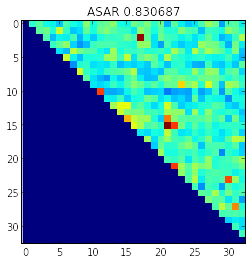

In [14]:
for sta in xcmax2.keys():
    figure()
    imshow(xcmax2[sta], interpolation="none")
    title("%s %f" % (sta, np.max(xcmax2[sta])))


In [15]:
def vis_correlation(sta, i, j):
    w1, w2, patch1, patch2 = get_correlated_waves(sta, i, j)
    
    w2d = w2.data.data
    w2d /= np.std(w2.data.data[~w2.data.mask])
    
    f = figure()
    ax = f.add_subplot(211)
    m1 = int(offset1[sta][i,j])
    m2 = int(offset2[sta][i,j])
    
    idxs = np.arange(max(0, m1-50), m1+len(patch1)+50)
    ax.plot(idxs, w2d[idxs])
    
    x1 = np.arange(m1, m1+len(patch1))
    ax.plot(x1, patch1/np.std(patch1))
    ax.set_title("%s %.3f %.3f" % (sta, xcmax1[sta][i,j], xcmax2[sta][i,j]))
    
    ax = f.add_subplot(212)
    idxs = np.arange(max(0, m2-50), m2+len(patch2)+50)
    print np.max(idxs), m2+len(patch2)
    ax.plot(idxs, w2d[idxs])
    
    x2 = np.arange(m2, m2+len(patch2))
    print np.min(x1), np.max(x2)
    ax.plot(x2, patch2/np.std(patch2))
    
   


908 859
739 858


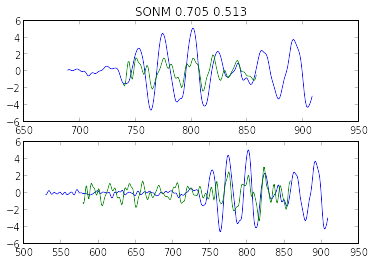

In [16]:
sta = "SONM"
am = np.argmax(xcmax1[sta]) 
vis_correlation(sta, am / n, am % n)

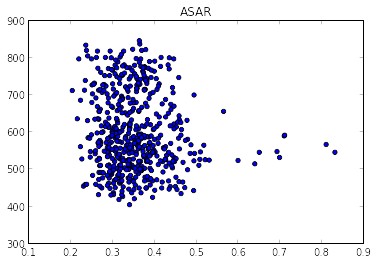

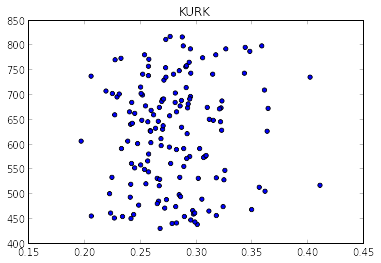

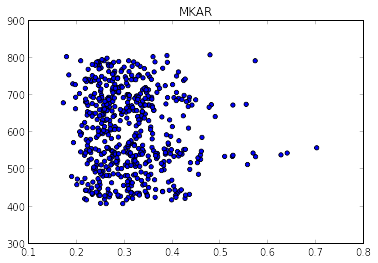

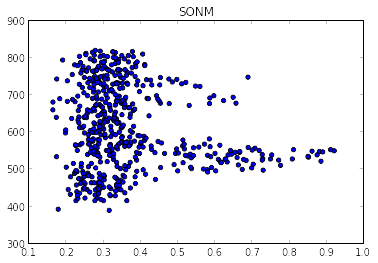

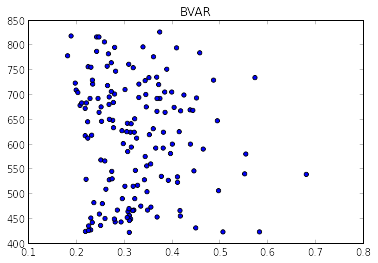

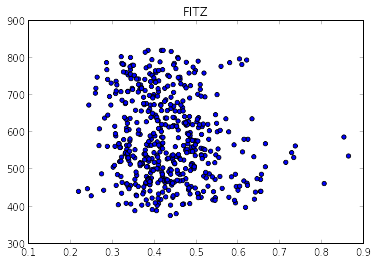

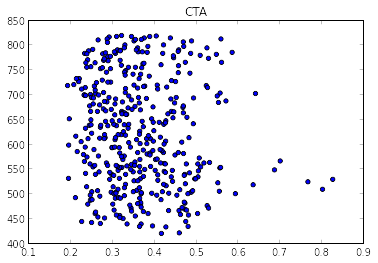

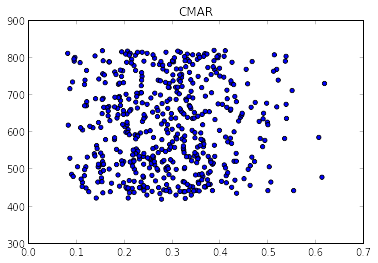

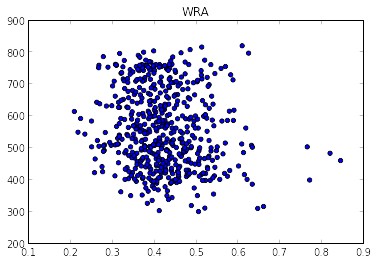

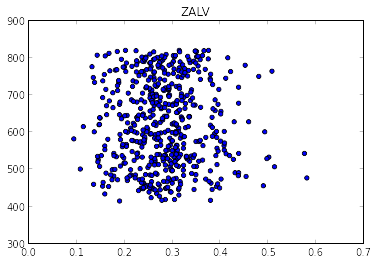

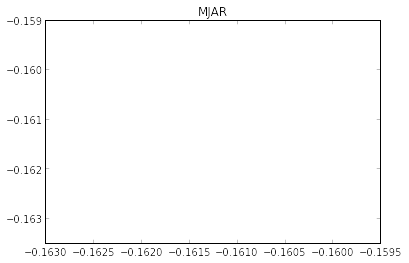

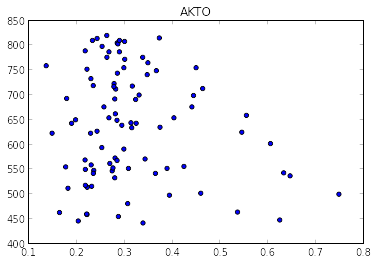

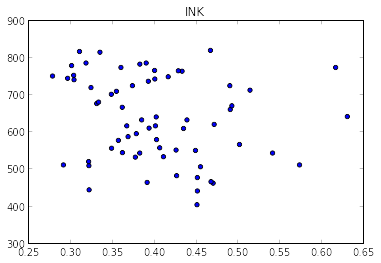

In [17]:
for sta in stas:
    figure()
    xcv = xcmax2[sta].flatten()
    ofv = offset2[sta].flatten()
    dd = np.abs(offset1[sta]-offset2[sta]).flatten()

    dd = dd[xcv > 0]
    ofv = ofv[xcv > 0]
    xcv = xcv[xcv > 0]

    scatter(xcv, ofv)
    title(sta)

In [18]:
w1, w2, p1, p2 = get_correlated_waves("CMAR", 1,12)
xcmax, offset, xc = xcorr_valid(p2, w2.data.data[400:900])

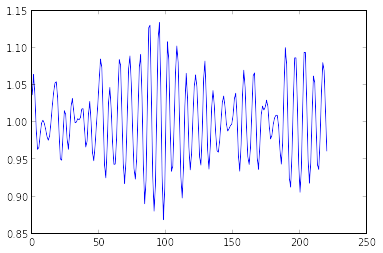

In [19]:
import scipy.stats
rv = scipy.stats.norm(loc=120, scale=60)
#lp = np.array([rv.pdf(x) for x in np.arange(len(xc))])
plot(np.exp(xc))

In [20]:
max_xc_thresholds={'ASAR': 0.6, 'MKAR': 0.5, 'KURK': None, 'SONM': 0.55, 
                   'BVAR': None, 'FITZ': 0.7, 'CTA': 0.6, 'CMAR': None, 'WRA': 0.7, 'ZALV': None,
                   'AKTO': 0.6, 'INK': None, 'MJAR': None}
difference_obs = {}
difference_obs_weights = {}
for sta in stas:
    if max_xc_thresholds[sta] is None: continue
    difference_obs[sta] = dict() #np.ones((n,n))*np.nan
    difference_obs_weights[sta] = dict()
    for i in range(n):
        evid1 = evids[i]
        for j in range(n):
            
            if xcmax2[sta][i,j] < max_xc_thresholds[sta]: continue
            if (sta=="SONM" or sta=="CTA" or sta=="MKAR") and offset2[sta][i,j] > 600: continue
                
            evid2 = evids[j]
            p_start_idx, p1_end_idx, p2_end_idx = patches[(sta, evid1)]
            offset = offset2[sta][i,j]
            time1=waves[evid1][sta]['stime']+(p_start_idx/float(srate))
            time2=waves[evid2][sta]['stime']+(offset/float(srate))
            #print evid1, evid2, time1, time2
            difference_obs[sta][(evid1, evid2)] = time2-time1
            
            difference_obs_weights[sta][(evid1, evid2)] = np.exp(2*xcmax2[sta][i,j]-1)

# Location from atimes

In [21]:
from sigvisa.models.ttime import tt_predict_grad
from sigvisa.models.distributions import Gaussian
from sigvisa.source.event import Event, get_event
from sigvisa import Sigvisa
from sigvisa.database.dataset import *

import scipy.optimize

def locate_event(ev0, atimes, ttmodels=None):
    
    def build_ev(x):
        return 
    
    base_x = np.array((ev0.lon, ev0.lat, ev0.depth, ev0.time))
    def nllgrad(rx):
        l = 0
        grad = np.zeros((4,))
        x = rx + base_x
        for sta in atimes.keys():
            model = ttmodels[sta] if (ttmodels is not None and sta in ttmodels) else Gaussian(0.0, 3.0)
            try:
                tt, ttgrad = tt_predict_grad(x[0], x[1], x[2], x[3], sta, 'P')
            except ValueError:
                l += -np.inf
                continue
                
            r = atimes[sta]-(x[3]+tt)
            ll = model.log_p(r)
            #print sta, atimes[sta], x[3]+tt, r, ll
            l += ll
            grad -= model.deriv_log_p(r) * np.array(ttgrad)
        return -l, -grad
    
    rx0 = np.zeros((4,))
    ll1, grad1 = nllgrad(rx0)
    r = scipy.optimize.minimize(nllgrad, rx0, jac=True, bounds=((-20, 20), (-20, 20), (0, 100), (-50, 50)))
    
    print "orig ll", ll1
    print r
    x = base_x + r.x
    return Event(lon=x[0], lat=x[1], depth=x[2], time=x[3], mb=ev0.mb)



In [22]:
from sigvisa.learn.train_param_common import load_modelid
from sigvisa.graph.sigvisa_graph import get_param_model_id, ModelNotFoundError
from collections import defaultdict

atimes = defaultdict(dict)
models = {}
s = Sigvisa()
cursor = s.dbconn.cursor()
dets = dict()
for evid in evids:
    dets[evid] = read_event_detections(cursor, evid)
cursor.close()

for evid in dets.keys():
    for det in dets[evid]:
        siteid = int(det[DET_SITE_COL])
        atime = det[DET_TIME_COL]
        phaseid = det[DET_PHASE_COL]
        if phaseid != 0: continue
        sta = s.siteid_minus1_to_name[siteid]
        atimes[evid][sta]=atime

        if sta not in models:
            try:
                modelid = get_param_model_id((28,), sta, "P", "constant_laplacian", "tt_residual",
                                   "lin_polyexp", band="freq_0.8_4.5")
                models[sta] = load_modelid(modelid)
            except ModelNotFoundError:
                continue

print models
    
ev0 = get_event(evid=evids[0])
print ev0

{'STKA': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x6277f50>, 'VNDA': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x62778d0>, 'DZM': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x6277250>, 'AAK': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x6277ad0>, 'AKTO': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x6277990>, 'KBZ': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x6277050>, 'PMG': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x6277850>, 'CTA': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x6277b90>, 'INK': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x6277dd0>, 'JKA': <sigvisa.models.spatial_regression.baseline_models.ConstLaplacianModel object at 0x62777d

# Locating from difference observations

In [23]:
from sigvisa.models.ttime import tt_predict_grad
from sigvisa.models.distributions import Gaussian
from sigvisa.source.event import Event, get_event
from sigvisa import Sigvisa
from sigvisa.database.dataset import *

import scipy.optimize


def locate_events_from_differences(ev0s, difference_obs, atimes=None, ttmodels=None, difference_base_std=0.1):
    
    base_x = []
    evid_idxs = {}
    sorted_evs = sorted(ev0s.items())
    for evid, ev0 in sorted_evs:
        evid_idxs[evid] = len(base_x)
        base_x += [ev0.lon, ev0.lat, ev0.depth, ev0.time]
        
    stas = difference_obs.keys() if difference_obs is not None  \
        else reduce(lambda a,b: a | b, [set(at.keys()) for at in atimes.values()])
        
    def nllgrad(rx):
        l = 0
        grad = np.zeros(rx.shape)
        x = rx + base_x
        
        
        
        for sta in stas:
            model = ttmodels[sta] if (ttmodels is not None and sta in ttmodels) else Gaussian(0.0, 3.0)
            
            
            if atimes is not None:
                for evid in atimes.keys():

                    try:
                        r = atimes[evid][sta]
                    except KeyError:
                        continue

                    i = evid_idxs[evid]
                    try:
                        tt, ttgrad = tt_predict_grad(x[i], x[i+1], x[i+2], x[i+3], sta, 'P')
                    except ValueError:
                        l += -np.inf
                        break

                    r -= (x[i+3]+tt)
                    ll = model.log_p(r)
                    l += ll
                    grad[i:i+4] -= model.deriv_log_p(r) * np.array(ttgrad)

            if difference_obs is not None:
                for evid1, evid2 in difference_obs[sta]:
                    i = evid_idxs[evid1]
                    j = evid_idxs[evid2]
                    try:
                        tt1, tt1grad = tt_predict_grad(x[i], x[i+1], x[i+2], x[i+3], sta, 'P')
                        tt2, tt2grad = tt_predict_grad(x[j], x[j+1], x[j+2], x[j+3], sta, 'P')
                    except ValueError:
                        l += -np.inf
                        break


                    r = difference_obs[sta][(evid1, evid2)]-(  (x[j+3]+tt1) - (x[i+3]+tt2) )
                    #print "%s %d %d: obs difference %f, pred %f (%f-%f), r %f" % (sta, evid1, evid2, difference_obs[sta][(evid1, evid2)], 
                    #                                                        (x[j+3]+tt1) - (x[i+3]+tt2), 
                    #                                                        x[j+3]+tt1, x[i+3]+tt1, r)

                    
                    diffmodel = Gaussian(0.0, difference_base_std)
                    ll = diffmodel.log_p(r)
                    l += ll
                    grad[i:i+4] -= model.deriv_log_p(r) * np.array(tt1grad)
                    grad[j:j+4] += model.deriv_log_p(r) * np.array(tt2grad)
            
        return -l, -grad
    
    n = len(base_x)
    rx0 = np.zeros((n,))
    ll1, _ = nllgrad(rx0)
    r = scipy.optimize.minimize(nllgrad, rx0, jac=True, bounds=[(-20, 20), (-20, 20), (0, 100), (-50, 50)]*len(ev0s))
    
    print "orig ll", ll1
    print "optimized ll", r.fun
    x = base_x + r.x
    evs = {}
    for i, (evid, ev0) in enumerate(sorted_evs):
        j = i*4
        evs[evid] = Event(lon=x[j], lat=x[j+1], depth=x[j+2], time=x[j+3], mb=ev0.mb)
    return evs


In [24]:
evs = load_evs()
evs_abs = locate_events_from_differences(evs, None, atimes, models)
evs_reloc = locate_events_from_differences(evs, difference_obs, None, models)
evs_full = locate_events_from_differences(evs, difference_obs, atimes, models)

orig ll 530.27323647
optimized ll 505.75265637
orig ll 45274.6854892
optimized ll 6344.38475201
orig ll 45471.5278208
optimized ll 18022.8793449


# Comparison to regional bulletin

In [25]:
import obspy.core.quakeml
s = Sigvisa()
cat = obspy.core.quakeml.readQuakeML(os.path.join(s.homedir, "experiments/regional.xml"))



In [26]:
"""
steps to a cov matrix.
a) convert an azimuth to a vector pointing in the appropriate direction (requires some research). this is the first eigenvector
b) find the normal, as the second eigvec
c) now we can compute C=VDV' to recover the cov matrix, in km, from its eigendecomposition
d) now find the length of a degree lon and degree lat, in KM, at the mean location. We'll scale by LCL', where L is 
   a diagonal matrix with the appropriate lengths, to get the cov matrix in degrees. 
"""

def azimuth_vector(azi_deg):
    angle_deg = 90 - azi_deg
    angle_rad = angle_deg * np.pi/180.0
    return np.array((np.cos(angle_rad), np.sin(angle_rad)))

def normal_vec(v1):
    return np.array((-v1[1], v1[0]))
    
def cov_matrix_km(azi_deg, var1, var2):
    v1 = azimuth_vector(azi_deg).reshape((-1, 1))
    v2 = normal_vec(v1).reshape((-1, 1))
    V = np.hstack((v1, v2))
    D = np.diag((var1, var2))
    return np.dot(V, np.dot(D, V.T))

def conf_to_var(x, confidence=0.9):
    one_sided = 1.0 - (1.0-confidence)/2
    z = scipy.stats.norm.ppf(one_sided)
    stddev = x/z
    return stddev**2

#

def linear_interpolate(x, keys, values):
    idx = np.searchsorted(keys, x, side="right")-1
    k1, k2 = keys[idx], keys[idx+1]
    v1, v2 = values[idx], values[idx+1]
    slope = (v2-v1)/(k2-k1)
    return v1 + (x-k1)*slope

def degree_in_km(lat):
    # source: http://en.wikipedia.org/wiki/Latitude#Length_of_a_degree_of_latitude
    refs = np.array([0, 15, 30, 45, 60, 75, 90])
    lat_table = [110.574, 110.649, 110.852, 111.132, 111.412, 111.618, 111.694]
    lon_table = [111.320, 107.550, 96.486, 78.847, 55.800, 28.902, 0.000]
    alat = np.abs(lat)
    return linear_interpolate(alat, refs, lon_table), linear_interpolate(alat, refs, lat_table)
    
def cov_km_to_deg(lat, C):
    klon, klat = degree_in_km(lat)
    L = np.diag((1.0/klon, 1.0/klat))
    return np.dot(L, np.dot(C, L.T))

def uncertainty_to_cov(ellipse, lat):
    x1 = ellipse.max_horizontal_uncertainty
    x2 = ellipse.min_horizontal_uncertainty
    azi_deg = ellipse.azimuth_max_horizontal_uncertainty
    C = cov_matrix_km(azi_deg, conf_to_var(x1), conf_to_var(x2))
    CC = cov_km_to_deg(lat, C)
    return CC



In [27]:

catalog_locations = {}
catalog_covs = {}
catalog_time_vars = {}

for evid in evids:
    ev = evs[evid]
    for i, cc in enumerate(cat):
        origin = cc.preferred_origin()
        timediff = np.abs(ev.time - origin.time.timestamp)
        if timediff < 10.0:
            catalog_locations[evid] = (origin.longitude, origin.latitude, origin.depth/1000.0, origin.time.timestamp)
            catalog_covs[evid] = uncertainty_to_cov(origin.origin_uncertainty, origin.latitude)
            #print evid, origin.origin_uncertainty.max_horizontal_uncertainty, origin.origin_uncertainty.azimuth_max_horizontal_uncertainty
            catalog_time_vars[evid] = conf_to_var(origin.time_errors.uncertainty)
            print "found match for evid", evid
            break
    if evid not in catalog_locations:
        print "no match for evid", evid

found match for evid 5334501
found match for evid 5334991
found match for evid 5334726
found match for evid 5335144
found match for evid 5349684
found match for evid 5335822
found match for evid 5348178
found match for evid 5334971
found match for evid 5349536
found match for evid 5335079
found match for evid 5335116
found match for evid 5335138
found match for evid 5350499
found match for evid 5336237
found match for evid 5335425
found match for evid 5335424
found match for evid 5349441
found match for evid 5336640
found match for evid 5335577
found match for evid 5350077
found match for evid 5336889
found match for evid 5335760
found match for evid 5336967
found match for evid 5337111
found match for evid 5336015
found match for evid 5337461
found match for evid 5351821
found match for evid 5351657
found match for evid 5336724
found match for evid 5351713
found match for evid 5338302
found match for evid 5338318
found match for evid 5338388


In [28]:
C = catalog_covs[5335144]
evl, evec = np.linalg.eig(C)
a = np.arctan(evec[0][1]/ evec[0][0]) * 180.0/np.pi
axes = np.sqrt(evl)*1.65

print evl
print evec[0]
print axes*110
print a

[ 0.00114673  0.00291431]
[-0.7268195  -0.68682852]
[ 6.14620538  9.79816036]
43.3795797561


In [29]:
banned_evids = set()
for evid in evids:
    ev = evs[evid]

    diffmax = np.max(catalog_locations[evid][:2] - np.array((ev.lon, ev.lat)))
    if diffmax < 1e-4:
        banned_evids.add(evid)
print banned_evids

set([5335424, 5335425, 5351821, 5336724, 5335577, 5351713, 5349684, 5336889, 5334971, 5350077, 5338302, 5349441, 5334726, 5335116, 5336015, 5335760, 5348178, 5335138, 5350499, 5335144, 5351657, 5337461, 5338388])


In [54]:
"""
Given a solution in the set of a dictionary of evs.
I want to 
a) plot the evs on the map, with colors
b) plot the regional evs with uncertainty ellipses
c) compute logp
"""

from sigvisa.plotting.event_heatmap import EventHeatmap
from sigvisa.utils.geog import dist_km

def plot_evs(evs, title=""):
    evids = sorted(catalog_locations.keys())
    ev_locs = [catalog_locations[evid] for evid in evids]
    ev_covs = [catalog_covs[evid] for evid in evids]
    dd_locs = [evs[evid] for evid in evids]
    
    hm = EventHeatmap(f=None, left_lon=129.0, right_lon=130.5, bottom_lat=-4.5, top_lat=-3.7, calc=False)
    
    
    hm.add_reference_events(locations=ev_locs, covs=ev_covs)
    
    hm.add_events(evs=dd_locs)
    f = plt.figure(figsize=(15, 15))
    ax = f.add_subplot(111)
    hm.plot(axes=ax, ev_alpha=1.0, colorseed=1)
    ax.set_title(title)
    
    locations = hm.event_locations
    ll = 0
    errs = []
    for i in range(len(ev_locs)):
        #if evids[i] in banned_evids: continue
        mean= ev_locs[i][:2]
        cov = ev_covs[i]
        loc = locations[i][:2]
        ll += scipy.stats.multivariate_normal(mean=mean, cov=cov).logpdf(loc)
        errs.append(dist_km(mean, loc))
    print "errors", errs
    print "ll", ll, ", error (km) mean %.2f std %.2f median %.2f" % (np.mean(errs), np.std(errs), np.median(errs))
    return ax

errors [4.987217931930167, 19.272968856796112, 0.0077508330571752822, 12.002498490045884, 14.984747783195292, 0.0015241140060188881, 22.43504763391865, 4.3237268074485948, 46.67980828799115, 39.092156566008398, 8.950886014580238, 22.427863337187542, 11.412066654997499, 0.0055344531099257846, 17.133703239200006, 15.200778710331186, 0.0059979969568645913, 0.0029002187672861868, 5.4293754786578212, 16.329153527818939, 0.0045722237522730557, 0.0036016350384722126, 77.965769459907619, 25.272855097580795, 20.019124600328382, 0.0046930734750803473, 20.094205889521575, 89.239069423327607, 0.0071570513093257146, 0.0037057936664928945, 0.0040359881896585171, 0.0029585959758435514, 0.0055152683615212195]
ll -337.464128312 , error (km) mean 14.95 std 21.06 median 8.95


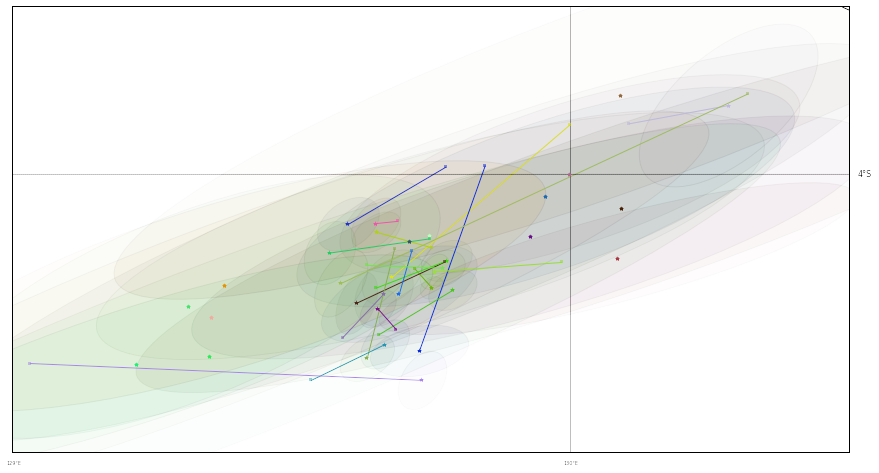

In [55]:
plot_evs(evs)
#print catalog_covs.values()

errors [11.825462992467902, 33.749250353942891, 9.8092406143296262, 26.547727183778463, 12.083806452011649, 21.163684411184839, 21.890434918865047, 9.0055247890567518, 10.571532719960683, 75.486375577399144, 19.281823730548606, 32.379558230748927, 31.448558535127965, 9.7582602552855153, 16.155962336090344, 14.207357229192445, 13.587419542409629, 22.795615239717705, 25.183705635642987, 32.424491354141317, 28.691069953505298, 9.5887881190058852, 109.24300248753077, 26.528581387194549, 8.3321363445868766, 9.6276159306623512, 31.702604842040159, 80.55237152871311, 9.2418496085780433, 9.3725971250219189, 26.774357931120328, 14.849793232862563, 11.754287069685937]
ll -544.891441931 , error (km) mean 25.02 std 22.16 median 19.28


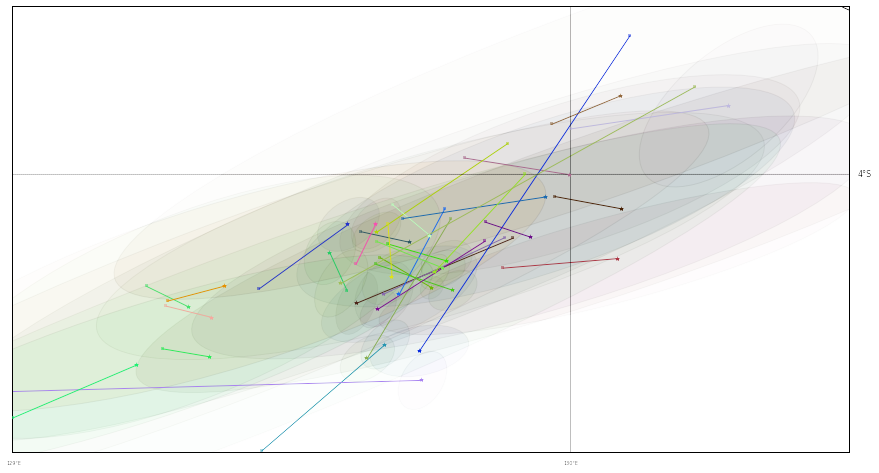

In [56]:
plot_evs(evs_abs)


errors [21.146025219172046, 20.81437657703157, 1.1749699925098172, 16.358148949984013, 35.207332710963719, 5.9814629484592725, 30.73255743995076, 8.2200482798692249, 18.124601573345931, 26.559431631029089, 17.037351255192462, 39.541713538148585, 57.208282028346915, 2.0118376699072105, 37.933550916114918, 8.2023342337775897, 2.2042103685308523, 1.2723731253265473, 14.896696675844366, 16.703534762847539, 0.85877055408582825, 3.4686793936536851, 75.597048409724096, 24.939894242398225, 16.000791834858536, 0.25623332500279827, 20.453204256394809, 89.15311555802208, 1.5704505402447158, 1.2056490924237686, 0.92182919353565884, 0.59518383543866715, 0.31990783240721027]
ll -588.841601099 , error (km) mean 18.69 std 21.37 median 16.00


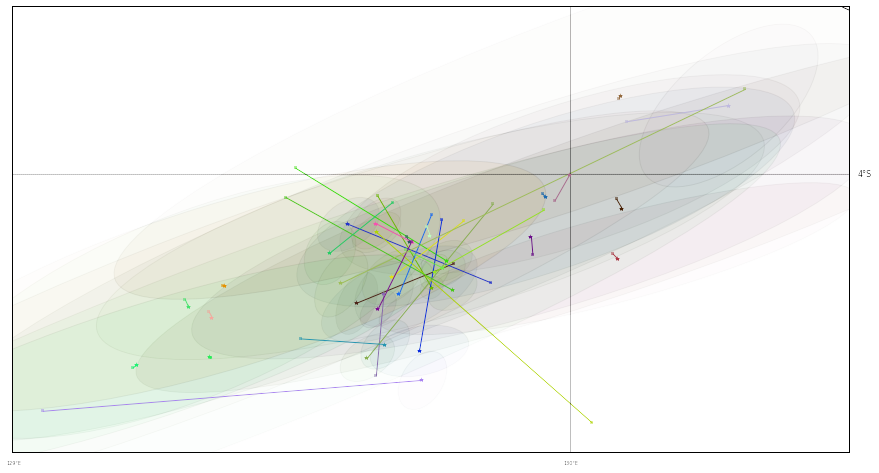

In [57]:
plot_evs(evs_full)


# Evaluating MCMC results

In [46]:
from sigvisa.infer.analyze_mcmc import load_trace, trace_stats
from sigvisa import Sigvisa
from sigvisa.source.event import Event
import os
#def load_posterior_means(mcmc_run, burnin=300)

mcmc_run=1726
burnin=300
s = Sigvisa()
mcmc_log_dir = os.path.join(s.homedir, "logs", "mcmc")
mcmc_run_dir = os.path.join(mcmc_log_dir, "%05d" % mcmc_run)
mcmc_evs = dict()
for fname in os.listdir(mcmc_run_dir):
    if not fname.startswith("ev_") or not fname.endswith(".txt"): continue
    eid = int(fname[3:8])
    ev_trace_file = os.path.join(mcmc_run_dir, fname)
    trace, min_step, max_step = load_trace(ev_trace_file, burnin=burnin)
    mean_ev = np.mean(trace[burnin:, :], axis=0)
    for evid in evids:
        ref_ev = evs[evid]
        timediff = ref_ev.time - mean_ev[3]
        if np.abs(timediff) < 30:
            mcmc_ev = Event(lon=mean_ev[0], lat=mean_ev[1], depth=mean_ev[2], time=mean_ev[3], mb=mean_ev[4])
            print mcmc_ev
            mcmc_evs[evid] = mcmc_ev
            break
    

evid None, loc 128.95 E 4.22 S, depth 98.2km, time 1240273214.2, mb 3.8, natural source
evid None, loc 127.85 E 5.02 S, depth 0.5km, time 1240293939.5, mb 3.2, natural source
evid None, loc 129.76 E 4.16 S, depth 0.1km, time 1240250347.4, mb 4.4, natural source
evid None, loc 130.57 E 3.71 S, depth 3.5km, time 1240240233.3, mb 2.9, natural source
evid None, loc 129.69 E 4.14 S, depth 7.8km, time 1240275880.9, mb 3.3, natural source
evid None, loc 130.06 E 3.87 S, depth 3.6km, time 1240265564.4, mb 3.5, natural source
evid None, loc 128.52 E 5.03 S, depth 0.7km, time 1240256363.8, mb 3.3, natural source
evid None, loc 129.67 E 4.14 S, depth 3.2km, time 1240276705.2, mb 4.3, natural source
evid None, loc 129.66 E 4.24 S, depth 0.2km, time 1240256947.7, mb 4.7, natural source
evid None, loc 129.21 E 3.93 S, depth 0.4km, time 1240247198.8, mb 3.3, natural source
evid None, loc 129.42 E 4.08 S, depth 0.3km, time 1240249061.9, mb 3.1, natural source
evid None, loc 129.76 E 4.10 S, depth 0.1k

errors [6.9494694992042412, 11.148221968394768, 59.907234692257632, 21.609568660911236, 1.9906600916853381, 20.070199638364752, 18.388637955167408, 20.779211229191258, 19.089419691431704, 24.17448929933553, 65.634376289867532, 21.532945186787458, 20.19556489543152, 11.620855145182608, 14.714918186967635, 2.7851407222207096, 130.74608722629691, 44.114924516859112, 2.6056897516158397, 12.153053938785337, 88.649276457223664, 30.416728870354302, 19.218240202610513, 62.920787010182686, 5.6134874618810686, 93.945495039044914, 98.342297259327793, 121.64545169782524, 39.966502473719508, 126.06429782310302, 29.384214175593595, 70.637236805944198, 192.05274306502716]
ll -529.265883172 , error (km) mean 45.73 std 45.64 median 21.61


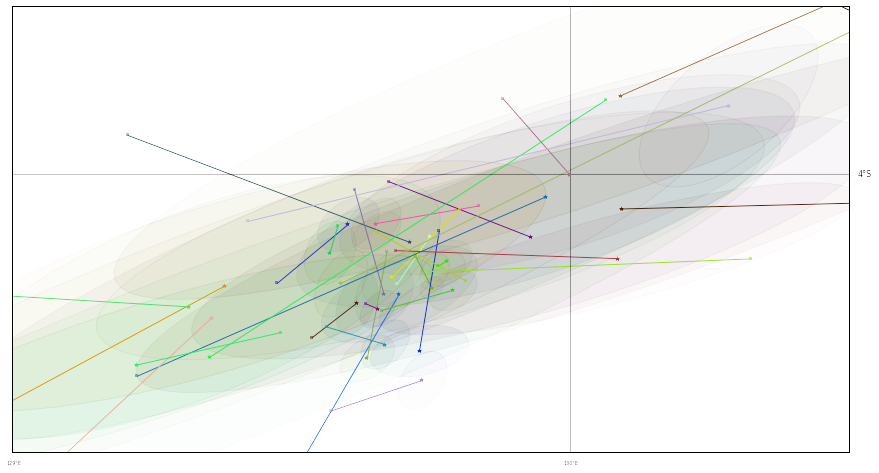

In [58]:
plot_evs(mcmc_evs)
